# Permutation Generation in PyTorch on GPU: Statistic Based Decision Rule for randperm vs. argsort and rand

## TL;DR

If you want quick guidance on choosing between `torch.randperm()` and `torch.argsort(torch.rand())` or `torch.argsort(torch.randint())` for generating (batch) permutations in PyTorch, go directly to the [Summary of Decision Rule](#decision-rule) section.


<a name="outline"></a>
## Outline

This document provides a statistical analysis for choosing between two methods of generating permutations in PyTorch:
-    `torch.randperm`
-    `torch.argsort(torch.rand()) or torch.argsort(torch.randint())`

This document provides an in-depth analysis of generating permutations in PyTorch, focusing on the performance and statistical properties of `torch.randperm` versus `torch.argsort` with `torch.rand` or `torch.randint`. The sections are summarized below:
 
1. **[Introduction](#intro)**: Discusses the basic functions `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint`, highlighting their use cases and limitations.
2. **[Bias in Permutations Generated by `torch.argsort` with `torch.rand`](#bias-in-permutations)**: Explains the issue of biased distributions due to duplicate numbers in random arrays and how `torch.randperm` mitigates this problem.
3. **[Cost Criteria for Collisions when Using `argsort` with Randomly Generated Numbers](#cost-criteria)**: Introduces the concept of a cost criterion $P_{\text{crit}}$ and a decision rule for deciding which method to use based on permutation length and the number of bits in the random number generator.
4. **[Coin Toss Binomial Distribution Approximation as a Normal Distribution](#coin-toss-binomial)**: Models the problem using a binomial distribution and approximates it as a normal distribution to simplify calculations
5. **[Best Guess Criterion: Single Set of K Tosses](#best-guess-criterion-single)**: Gives the mathematical model for $P_{\text{crit}}(K; X)$ for a single permutation based on statistical analysis.
6. **[Best Guess Criterion: N Sets of K Tosses](#best-guess-criterion-multi)**: Extends the model to multiple permutations and derives bounds for the transition zone.
7. **[Summary of Decision Rule](#decision-rule)**: Provides a practical decision rule for choosing the appropriate PyTorch batch permutation generation method (if any) based on the analysis.
8. **[Additional Considerations](#additional-considerations)**: Discusses the simplification $\sigma_b \approx \sigma_f$, alternative criteria, and empirical testing for determining the effective number of bits in the float type.
9. **[Conclusion](#conclusion)**: Summarizes the findings and the practical guidelines derived from the analysis.


<a name="intro"></a>
## 1. Introduction

The PyTorch library, widely used for neural networks on a GPU, supplies a function `torch.randperm(length)` that returns a permutation in a one-dimensional tensor, e.g.,
```python
>>> torch.randperm(6)
tensor([5, 3, 2, 4, 0, 1])
```
However, `torch.randperm` has a drawback - it cannot produce multiple permutations in batch mode. In PyTorch, batch mode refers to processing multiple inputs simultaneously, which improves performance.

A similar result can be obtained by using `torch.argsort` with `torch.rand` or `torch.randint`:
```python
>>> torch.argsort(torch.rand(6))
tensor([4, 3, 2, 5, 0, 1])
```
Unlike `torch.randperm`, `torch.argsort` with `torch.rand` or `torch.randint` can be used to produce a multidimensional tensor of permutations:
```python
# Create a batch of 3 permutations of length 6
>>> torch.argsort(torch.rand(3, 6))
tensor([[4, 3, 2, 5, 0, 1],
        [2, 5, 1, 0, 3, 4],
        [0, 3, 1, 5, 2, 4]])
```

The difference in speed becomes significant when utilizing a GPU to process tensors in parallel in a batch call, which may be faster per permutation by orders of magnitude. However, if there is no need to create multiple permutations or no need for speed, then using `randperm` is sufficient.

[To outline](#outline)

<a name="bias-in-permutations"></a>
## 2. Bias in Permutations Generated by `torch.argsort` with `torch.rand`

How does `torch.randperm` differ from and perform better than `torch.argsort(torch.rand...)`?

The issue is that among the arrays of random numbers produced by `torch.rand` and `torch.randint` are arrays that include duplicate numbers (also known as collisions). That, in turn, biases the distribution of permutations produced by sorting those arrays with `torch.sort`.

```python
>>> a = torch.randint(low=10, high=16, size=(6,))
tensor([11, 12, 15, 12, 11, 10])
>>> torch.sort(a, stable=True)
torch.return_types.sort(
values=tensor([10, 11, 11, 12, 12, 15]),
indices=tensor([5, 0, 4, 1, 3, 2]))
```

In the above example, the value of the parameter range `high - low` was set artificially low to 6 to induce duplicate values to be sorted. As a result, the sorted indices `0, 4`, corresponding to the duplicate sorted values `11, 11`, are arranged in ascending order (guaranteed by a stable sort, which maintains the relative order of equal elements). Likewise, indices `1, 3` are in ascending order. The resulting distribution of sorted indices is not symmetric because it is biased to have more ascending pairs than descending pairs, as a result of duplicates.

In contrast, the function `torch.randperm` is written to detect any duplicate keys and partially recalculate the results to remove the effects of those duplicate keys. The recalculation consists of regenerating keys for, and resorting only, those intervals with compromised values after the initial sort is complete. The result is almost perfect (excepting the tiny chance of the regenerated keys also having duplicates - it doesn't use a loop to eliminate that possibility). By using `torch.randperm`, the possibility of a biased distribution is (almost) eliminated.

[To outline](#outline)

<a name="cost-criteria"></a>
## 3. Cost Criteria for Collisions when Using `argsort` with Randomly Generated Numbers


The user generating multiple permutations of length $K$ must decide which form to use:
- A batch of permutations capable call to `argsort(rand...(batch_count, K))` which may have a biased result.
- Multiple single permutation only calls to `randperm(K)` which is (almost) unbiased.

Furthermore, the batch capable call may be any of these three forms:
- `argsort(rand(batch_count, K))` where the `rand` call returns values of type `torch.float32`, and uses a 24-bit random number generator.
- `argsort(randint(low=-2**31, high=2**31-1, (batch_count, K), dtype=torch.integer32)` where the `randint` call returns values of type `torch.integer32` and uses a 32-bit random number generator (\*1).
- `argsort(randint(low=-2**63, high=2**63-1, (batch_count, K), dtype=torch.integer64)` where the `randint` call returns values of type `torch.integer64` and uses a 64-bit random number generator (\*1).

> *\* Note 1: The PyTorch documentation for `randint` parameters says "high (int) – One above the highest integer to be drawn from the distribution." Therefore, we would expect the setting `high=2**31` to be appropriate. However, this has been found to lead to errors in some PyTorch versions.*

As will be shown, a higher number of bits in the random number generator will produce a less biased distribution of permutations. On the other hand, the `integer64` bit version uses twice the memory as the `integer32` bit version, allowing for less parallelization and thus being slower. Both `float32` and `integer32` use the same amount of memory, but the `rand()` form of the call has been anecdotally seen to be a few percent faster than `randint()` with `integer32` form, although this may vary by system.

This document will define a family of criteria $P_{\text{crit}}(K;m, N)$ that can be used to determine whether a particular length $K$ and random bits $m$ will have too many collisions, or not.

- $K$ is the permutation length, fixed with respect to the decision rule,
- $m \in \{24, 32, 64\}$ corresponds to the three forms of calling random number generation shown above. 
- $N$ is free parameter for $P_{\text{crit}}(K; m, N)$, set per application depending on how risk/benefit is calculated.  A value of $N=1$ means risk/benefit is calculated independently per permutation.

The statistical measure $P_{\text{crit}}(K; m, N)$ is defined such that given a random permutation generated by either `randperm(K)` or `torch.argsort(torch.rand(K))` with a 50% chance of each method being used, but without knowing which method was used. $P_{\text{crit}}(K; m, N)$ is the probability of guessing correctly which distribution the sample was drawn from, using an optimal guessing strategy.

We then constrain the value of $P_{\text{crit}} < C_{\text{thresh}}$ to define our desired risk model. For example, setting $P_{\text{crit}} < 0.55$ means we would be able to correctly guess whether a permutation came from the fair or biased distribution 11 out of 20 times, or 55% percent of the time. The mathematical range of $P_{\text{crit}}$ is between $0.5$ and $1$, corresponding to 50% to 100%. However, we will only consider the range $0.50$ to $0.55$, because beyond that the model loses accuracy.

Section ["Modeling Sorted Collisions as a Binomial of Coin Tosses with a Biased Coin"](#coin-toss-binomial) shows how the fair and biased distributions of permutations length $K$ can be modelled using a binomial distribution of $K$ coins tosses.

Section ["Best Guess Criterion: Single Set of K Tosses"](#best-guess-criterion-single) introduces the model for $P_{\text{crit}}(K; m, N)$, with $N=1$, as described above.

Section ["Best Guess Criterion: N Sets of K Tosses"](#best-guess-criterion-multi) adds another parameter, $N$, to give $P_{\text{crit}}(K;m,N)$, where $N>=1$.

An obvious question is: *Why model a single permutation (i.e. $N=1$) when the whole reason to use `argsort` with `random` instead of `randperm` is the advantage of batch production of permutations?*

The answer is that even in such cases, it may be the cost/benefit ratio per single permutation that is relevant.

The canonical counter-example would be, of course, the application of calculating the exact cost criterion over $N$ permutations.

Therefore, $N$ serves as another free parameter (in addition to $C_{\text{thresh}}$) that can be set appropriately per application.

[To outline](#outline)

<a name="coin-toss-binomial"></a>
## 4. Modeling Sorted Collisions as a Binomial of Coin Tosses with a Biased Coin


Consider the output of a call of torch.randperm(), assuming that it is a perfectly unbiased result. Because the indices in the result are unique, each adjacent pair is either ascending or descending. For our model, we will wrap the vector and count element pair $[K-1, 0]$ of the result as another pair, so that the number of adjacent pairs is $K$. (This is one too many, but it is convenient and a sufficient approximation). We can model this distribution of ascending and descending pairs as the binomial $(K, p)$ for $K$ coin tosses, where:

- an ascending pair is heads
- a descending pair is tails
- $p = \frac{1}{2}$ is the probability of heads

In the call torch.argsort(torch.rand...), argsort returns a tuple (values, indices) in which values is the sorted array and indices is the array of indices of the sorted array. This can likewise be modeled as a binomial $(K, q)$ for $K$ coin tosses

- ascending is heads
- descending is tails
- $q \geq \frac{1}{2}$ is the probability of heads
- $q - \frac{1}{2} \geq 0$ is the bias (towards heads) of a coin

For a single output length $K$ output by torch.rand(...), the expected number of collisions is:

$$ \begin{aligned} E[N_\text{collisions}] &= \frac{1}{2^m} \cdot \frac{K(K-1)}{2} \ &= \frac{K(K-1)}{2^{m+1}} \end{aligned} $$

where $K$ is the permutation length and $m$ is the number of bits in the random keys.

In [Section 2](#bias-in-permutations) it was demonstrated that each collision of two values, after sorting, resulted in a forced ascending pair. Therefore, we decide to model the biased binomial probability $q$ as

$$ 
\begin{aligned} q &= \frac{E[N_\text{collisions}] + \frac{1}{2}(K - E[N_\text{collisions}])}{K}
&= \frac{1}{2} + \frac{(K-1)}{2^{m+2}}
\end{aligned} 
$$

so that the bias $d$ is

$$ 
\begin{aligned} d &= q - \frac{1}{2} \\
&= \frac{(K-1)}{2^{m+2}} 
\end{aligned} 
\tag{1} 
$$

This model has made the simplifying assumption that each collision corresponds to a single adjacent forced ascending pair. This is only true if no more than two occurrences of every unique value exist. That is the case in the example.

In actuality, we may have any number of occurrences up to $K$. A single value with $n$ occurrences would actually be counted as $\frac{n(n-1)}{2}$ collisions in equation 0.1, corresponding to an actual count of $n-1$ forced heads. However, our model would count $\frac{n(n-1)}{2}$ collisions as the same number $\frac{n(n-1)}{2}$ of forced heads.

In order for the model to be accurate we must be operating in the range where three or more occurrences of the same value are extremely rare. That is shown in Section 7.2.

### From Binomal to a Continuous Approximation

The de Moivre–Laplace theorem states that the binomial distribution $(K, p)$ converges as $K \rightarrow \infty$ to the probability density function of the normal distribution with mean $Kp$ and variance $Kp(1-p)$. We will use that approximation.

For a fair coin:

$$
\sigma_f = \sqrt{\frac{K}{4}}
\tag{2}
$$

$$
\mu_f = \frac{K}{2}
\tag{3}
$$

$$
P_f(x) = \text{Normal}(x; \mu_f, \sigma_f)
$$

For a biased coin, $d \ne 0$:

$$
\begin{aligned}
\sigma_b &= \sqrt{K (\frac{1}{2}+d)(\frac{1}{2}-d)} \\
&= \sqrt{K \left(\frac{1}{4} - d^2\right)}
\end{aligned}
\tag{4}
$$

$$
\mu_b = K \left(\frac{1}{2} + d \right)
\tag{5}
$$

$$
P_b(x) = \text{Normal}(x; \mu_b, \sigma_b)
\tag{6}
$$

[To outline](#outline)

<a name="best-guess-criterion-single"></a>
## 5. Best Guess Criterion: Single Set of K Tosses


We assume a scenario where a guesser, who knows the value of $d$, observes the random variable $x$ and must guess whether it came from the "fair" or from the "biased" distribution. The guesser will always choose the distribution with the highest probability for $x$, which is

$$
\text{Best}(x) = \delta(P_b(x)>P_f(x)) 
$$

where $\delta(\cdot)$ is the indicator function that returns 1 if its argument is true and 0 otherwise.

While the guesser does not know the true distribution, we do know that the true distribution is the biased one. Therefore, the probability of a correct guess $P_{\text{crit}}$ is

$$
P_{\text{crit}} = \int \text{Best}(x) P_b(x) dx
\tag{7.pre1}
$$

At this point, we will make a simplifying assumption that $d^2$ is small enough that we can ignore it. This allows us to write:

$$
\begin{aligned}
P_b(x) &= \text{Normal}(x; \mu_b, \sigma_f)\\
&= P_b(x)
\end{aligned}
\tag{6.1}
$$

where $\sigma_f$ has replaced $\sigma_b$ in equation 6, since $\sigma_b = \sqrt{K\left(\frac{1}{4} - d^2\right)} \approx \sigma_f = \sqrt{\frac{K}{4}}$ when $d^2$ is small.

Then the best guess borderline is exactly at the midpoint between the two means, $\mu_f$ and $\mu_b$, because the normal distributions have equal variance.

Following from equation 7.pre1, the probability of a correct guess $P_{\text{crit}}$ is then:

$$
\begin{aligned}
P_{\text{crit}} &= \int_{\mu_f+\frac{\mu_b-\mu_f}{2}}^{\infty} P_b(x) dx \\
&= 1 - \text{cdf}(\mu_f+\frac{\mu_b-\mu_f}{2}; \mu_b, \sigma_f)\\
&= \text{cdf}(\mu_f+\frac{\mu_b-\mu_f}{2}; \mu_f, \sigma_f) \text{ (by symmetry of normal distribution)}\\
&= \text{cdf}(\frac{\mu_b-\mu_f}{2}; 0, \sigma_f) \text{ (by translation invariance)}\\
&= \text{cdf}(\frac{\mu_b-\mu_f}{2\sigma_f}; 0, 1) \text{ (by scaling invariance)}\\
\end{aligned}
\tag{7}
$$

where $\text{cdf}(x; \mu, \sigma)$ is the cumulative distribution function of the normal distribution with mean $\mu$ and standard deviation $\sigma$ evaluated at $x$.


The following plot illustrates how the probability of a correct guess can be calculated by integrating the area under the red curve (the biased coin) to the right of the vertical line (the best-guess cutoff at $0.25$). For the purposes of illustration, these arbitrary values are used: $\sigma_b = 0.5$, $\mu_f=0$, and $\mu_b = 0.5$.


<a name=figure-1></a>Figure 1

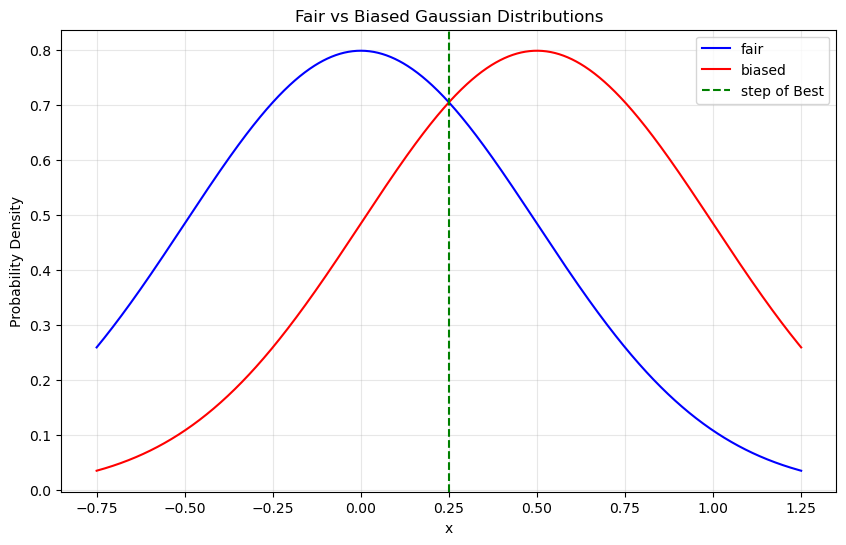

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Define the parameters
mean_f = 0      # mean for fair distribution
mean_b = 0.5    # mean for biased distribution
std = 0.5       # standard deviation (sqrt of variance 1/4)

# Create x values for plotting
x = np.linspace(-0.75, 1.25, 1000)

# Calculate y values for both Gaussian distributions
fair = np.exp(-(x - mean_f)**2 / (2 * std**2)) / (std * np.sqrt(2 * np.pi))
biased = np.exp(-(x - mean_b)**2 / (2 * std**2)) / (std * np.sqrt(2 * np.pi))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both Gaussian distributions
plt.plot(x, fair, 'b-', label='fair')
plt.plot(x, biased, 'r-', label='biased')

# Add vertical line at x=0.25
plt.axvline(x=0.25, color='g', linestyle='--', label='step of Best')

# Add labels and title
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Fair vs Biased Gaussian Distributions')
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
display(Markdown("<a name=figure-1></a>Figure 1"))
plt.show()



In the above graph, $P_{\text{crit}}$ is the area under the red curve to the right of the dashed green vertical line.

The higher $P_{\text{crit}}$, the more different the two distributions are, and the less suitable $P_b$ is as a substitute for $P_f$. With $P_{\text{crit}}$, when the bias is $0$, $P_{\text{crit}} = \frac{1}{2}$ because $P_f$ and $P_b$ are indistinguishable, and the best guess has only a $\frac{1}{2}$ probability of success. As the distributions become more distinguishable, $P_{\text{crit}}$ approaches $1$.


Substituting $\sigma_f$, $\mu_f$, and $\mu_b$ from equations 2, 3, and 5 to express $P_{\text{crit}}$ in terms of $K$ and $m$:

$$
\begin{aligned}
P_{\text{crit}} &= \text{cdf}(\frac{\mu_b-\mu_f}{2\sigma_f}; 0, 1)\\
&= \text{cdf}(\frac{Kd}{2\sqrt{K/4}}; 0, 1)\\
&= \text{cdf}(\sqrt{K}\ d; 0, 1)
\end{aligned}
\tag{9}
$$

Then substitute equation 1 for $d$:

$$
P_{\text{crit}}(K;m) = \text{cdf}(\frac{\sqrt{K}(K-1)}{2^{m+2}}; 0, 1)
\tag{9.1}
$$


<!-- ### Formula for $K$ -->

We would like to know, for a given value of $P_{\text{crit}}$ and $n$, what is maximum value of $K$ allowable?

First note that the $\text{cdf}(c)$ can be replaced by the error function $\text{erf}$ with scaling:

$$
\begin{aligned}
p &= \text{cdf}(c) \\
&= \frac{(1 + \text{erf}(\frac{c}{\sqrt(2)}))}{2}
\end{aligned}
$$

Then the solution for $c$ in terms of $p$ is

$$
c = \sqrt{2}\ \text{erfinv}(2*p - 1)
$$
where $\text{erfinv}$ is the inverse error function.  $c$ is the multiple of standard deviations. The value $c=1$ is one standard deviation.  


Substituting $c= \frac{\sqrt{K}(K-1)}{2^{m+2}}$ and approximating the $K-1$ term as $K$, 

$$
\begin{aligned}
& c = \frac{\sqrt{K}(K)}{2^{m+2}} \\
\rightarrow & \log_2(c) = \frac{3}{2} \log_2(K) - (m+2)\ \ \ \ \ \text{(taking logs of both sides)} \\ 
\rightarrow & \log_2(K) = \frac{2}{3}(\log_2(c) + m + 2)\ \ \ \ \ \text{(in terms of}\ \log_2(K)\text{)} \\
\rightarrow & \log_2(K) = \frac{2}{3}(\log_2(\sqrt{2}\ \text{erfinv}(2*P_{\text{crit}} - 1)) + m + 2)\ \ \ \ \ \text{(substitute for c)}\\
\end{aligned}
\tag{9.2}
$$

With equation 9.2 we can calculate the largest value of $\log_2(K)$ that will satisfy given values of $P_{\text{crit}}$ and $m$.  The following function `calculate_log2K(p_crit, m)` does that.

<a name="calculate-log2K"></a>
Code 1.  The function `calculate_log2K`

In [59]:
import numpy as np
import pandas as pd
from scipy.special import erfinv

def calculate_log2K(p_crit, m, log2_N = 0):
    """
    Calculate log2(K) using the formula:
    log2(K) = (2/3) * (log2(sqrt(2) * erfinv(2*P_crit - 1)) + m + 3) - log2(N)/3
    
    Args:
        p_crit (float): Critical probability value
        m (int): Column value (24, 32, or 64)
    
    Returns:
        float: Calculated log2(K) value
    """
    return (2/3) * (np.log2(np.sqrt(2) * erfinv(2*p_crit - 1)) + m + 2) \
        - log2_N / 3

def create_table(log2_N = 0):
    # Define input values
    p_crit_values = [0.501, 0.51, 0.55]
    m_values = [24, 32, 64]
    
    # Create empty DataFrame
    results = pd.DataFrame(index=p_crit_values, columns=m_values)
    
    # Fill in the values
    for p in p_crit_values:
        for m in m_values:
            results.loc[p, m] = calculate_log2K(p, m, log2_N)
    
    # Format the DataFrame
    results.index.name = 'P_crit'
    results.columns.name = 'm'
    
    return results

if __name__ == "__main__":
    # Calculate and display the table
    table = create_table()
    print("\nTable of log2(K) values:")
    print(table.round(4))  # Round to 4 decimal places for readability




Table of log2(K) values:
m              24         32         64
P_crit                                 
0.501    11.57331  16.906644  38.239977
0.510   13.788029  19.121362  40.454695
0.550   15.338409  20.671742  42.005075


The $\log_2(K)$ values are upper bounds on the length $K$ that will satisfy the desired level of accuracy specified by $P_{\text{crit}}$ and number of bits $m$ used for generating the random numbers.

For example, with $P_{\text{crit}} = 0.55$ and $m=24$, a permutation length of $K=32,268 = 2^{15}$ would satisfy the critieria.

[To outline](#outline)


<a name="best-guess-criterion-multi"></a>
## 6. Best Guess Criterion: N Sets of K Tosses

This section adds another parameter $N$ to the criterion giving $P_{\text{crit}}(K;m,N)$. The reasoning behind $P_{\text{crit}}$ is the same, but instead of one set of $K$ coin tosses, the model considers $N$ set of $K$ coin tosses.




Equation 1 for $d$ does not change at all. Independent of $N$, $d$ is always:

$$
d = \frac{K-1}{2^{m+2}}
\tag{1}
$$

However, equations 2, 3, 4, and 5 would change, with $K$ being replaced by the product $NK$.

For a fair coin:

$$
\sigma_f = \sqrt{\frac{NK}{4}}
\tag{2.N}
$$

$$
\mu_f = \frac{NK}{2}
\tag{3.N}
$$

For a biased coin, $d \ne 0$:

$$
\begin{aligned}
\sigma_b &= \sqrt{NK (\frac{1}{2}+d)(\frac{1}{2}-d)} \\
&= \sqrt{NK \left(\frac{1}{4} - d^2\right)}
\end{aligned}
\tag{4.N}
$$

$$
\mu_b = NK \left( \frac{1}{2} + d \right)
\tag{5.N}
$$

Substituting into equation 9:

$$
\begin{aligned}
P_{\text{crit}} &= \text{cdf}(\frac{NKd}{2}; 0, \frac{\sqrt{NK}}{2}) \\
&= \text{cdf}(\sqrt{NK}\ d; 0, 1)
\end{aligned}
\tag{9.N}
$$

Substituting for $d$:

$$
P_{\text{crit}} = \text{cdf}(\frac{\sqrt{NK}\ (K-1)}{2^{m+2}}; 0, 1)
$$

The equation for $K$ corresponding to equation 9.2 is 

$$
\begin{aligned}
\log_2(K) &= \frac{2}{3}(\log_2(\sqrt{2}\ \text{erfinv}(2*P_{\text{crit}} - 1)) + m + 2) - \frac{\log_2(N)}{3}
          &= \log_2(K) \mid_{N=1}  - \frac{\log_2(N)}{3}
\end{aligned}
\tag{9.N.2}
$$

The first line in equation 9.N.2 shows that the only difference with equation 9.2 is the final subtrahend $\frac{\log_2(N)}{3}$.  

The second line in equation 9.N.2 shows the value of $\log_2(K)$ becoming zero when 
$$
\log_2(N) = 3\ \log_2(K) \mid_{N=1}
$$
where $\log_2(K) \mid_{N=1}$ is $\log_2(K)$ when $N=1$.  In fact the approximation breaks for low values of $K$ because we used $K-1 \approx K$ earlier in equation 9.2, so that is not an exact result.


With $N=2^{16}=65,356$ calculate another table using the function `calculate_log2K` from [Code 1](#calculate-log2K):

In [54]:
if __name__ == "__main__":
    # Calculate and display the table
    table = create_table(log2_N=16)
    print("\nTable of log2(K) values with N=2**16:")
    print(table.round(4))  # Round to 4 decimal places for readability



Table of log2(K) values with N=2**16:
m              24         32         64
P_crit                                 
0.501    6.239977   11.57331  32.906644
0.510    8.454695  13.788029  35.121362
0.550   10.005075  15.338409  36.671742


In this new table with $N=2^{16}$ instead of $N=1$, but with $P_{\text{crit}} = 0.55$ and $m=24$ as before, a permutation length of $K=32,268 = 2^{15}$ would no longer satisfy the criterion.  However, for a value of $m=32$ it would satisfy the criterion.

[To outline](#outline)

<a name=decision-rule></a>
## 7. Summary of Decision Rule

Given the need to create permutations of length $K$ by batch, and being willing to tolerate bias as specified by $P_{\text{crit}}$ in $(0.5,0.55]$, and accumulated risk factor $N$, the following code will display a table of which batch call are valid.  If none are valid, use `torch.randperm`.



In [55]:

def show_call_validty(K, p_crit, N=1):
    def is_valid(n):
        if calculate_log2K(p_crit,n,np.log2(N)) >= np.log2(K):
            return "✓"
        else: return "✗"


    md = f"""

**Call Validities for log2(K)={np.log2(K):.4f}, P_crit={p_crit}, log2(N)={np.log2(N):.4f}** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | {is_valid(24)} | {calculate_log2K(p_crit,24,np.log2(N)):.4f} |
| 32 | {is_valid(32)} | {calculate_log2K(p_crit,32,np.log2(N)):.4f} |
| 64 | {is_valid(64)} | {calculate_log2K(p_crit,64,np.log2(N)):.4f} |
"""
    
    display(Markdown(md))


display(Markdown("""
**Correspondence between $m$ and PyTorch call form**
| m | call |
| -- | -- |
|24 | `argsort(rand((batch_count,K)))` |
|32 | `argsort(randint(low=-2**31,high=2**31-1,(batch_count,K),dtype=integer32))` |
|64 | `argsort(randint(low=-2**63,high=2**63-1,(batch_count,K),dtype=integer64))`
"""))

show_call_validty(K=32*1024, p_crit=0.55, N=1)
show_call_validty(K=32*1024, p_crit=0.55, N=2**16)

display(Markdown("""

#### Explore the limits of using `randint` with 64 bits:

"""))

show_call_validty(K=32*1024*1024, p_crit=0.55, N=64*1024*1024)
show_call_validty(K=32*1024*1024, p_crit=0.50001, N=64*1024*1024)
show_call_validty(K=32*1024*1024, p_crit=0.500001, N=64*1024*1024)


**Correspondence between $m$ and PyTorch call form**
| m | call |
| -- | -- |
|24 | `argsort(rand((batch_count,K)))` |
|32 | `argsort(randint(low=-2**31,high=2**31-1,(batch_count,K),dtype=integer32))` |
|64 | `argsort(randint(low=-2**63,high=2**63-1,(batch_count,K),dtype=integer64))`




**Call Validities for log2(K)=15.0000, P_crit=0.55, log2(N)=0.0000** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | ✓ | 15.3384 |
| 32 | ✓ | 20.6717 |
| 64 | ✓ | 42.0051 |




**Call Validities for log2(K)=15.0000, P_crit=0.55, log2(N)=16.0000** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | ✗ | 10.0051 |
| 32 | ✓ | 15.3384 |
| 64 | ✓ | 36.6717 |




#### Explore the limits of using `randint` with 64 bits:





**Call Validities for log2(K)=25.0000, P_crit=0.55, log2(N)=26.0000** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | ✗ | 6.6717 |
| 32 | ✗ | 12.0051 |
| 64 | ✓ | 33.3384 |




**Call Validities for log2(K)=25.0000, P_crit=0.50001, log2(N)=26.0000** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | ✗ | -1.5226 |
| 32 | ✗ | 3.8107 |
| 64 | ✓ | 25.1441 |




**Call Validities for log2(K)=25.0000, P_crit=0.500001, log2(N)=26.0000** 
|m| valid | max allowed log2(K) |
| -- | -- | -- |
| 24 | ✗ | -3.7372 |
| 32 | ✗ | 1.5961 |
| 64 | ✗ | 22.9295 |


As can be seen in result under **"Explore the limits of using randint with 64 bits"**, using 64-bit version will produce unbiased result for all but the most extreme cases.

[To outline](#outline)

<a name="additional-considerations"></a>
## 8. Additional Considerations

### 8.1 $d^2$ is small for the solution $P_{\text{crit}}=0.55$

Our decision to use the simplification $\sigma_b \approx \sigma_f$ in equation 6.1 was conditioned on $d^2$ having a very small value, where $d$ is given in equation 1. The following table shows that for the case of $N=1$, the values of $d^2$ are indeed very small, and that the simplification is justified.

In [56]:

def create_detailed_table(p_crit=0.55):
    # Initialize lists to store values
    data = []
    m_values = [24, 32, 64]
    
    for m in m_values:
        log2_K = calculate_log2K(p_crit, m)
        K = 2**log2_K
        d = (K-1) / 2**(m+3)
        dsq = d*d
        
        data.append({
            'm': m,
            'log2(K)': log2_K,
            'd': d,
            'd^2': dsq
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df.set_index('m', inplace=True)
    
    return df

if __name__ == "__main__":
    # Calculate and display the table
    table = create_detailed_table(p_crit=0.55)
    print(f"\nTable for p_crit = 0.55, N=1:")
    print(table.round(10))  # Adjust decimal places as needed


Table for p_crit = 0.55, N=1:
      log2(K)             d           d^2
m                                        
24  15.338409  3.086745e-04  9.530000e-08
32  20.671742  4.861430e-05  2.400000e-09
64  42.005075  2.990000e-08  0.000000e+00



Just for the sake of discussion, if the simplification $\sigma_b \approx \sigma_f$ had not been used, we could still have found the boundary condition where $P_f$ and $P_b$ were equal by solving

$$ 
\text{Normal}(x; \mu_b, \sigma_b) - \text{Normal}(x; \mu_f, \sigma_f) = 0
$$ 
for $x$, to get the x-axis location for point where the fair and biased distribution are equal, as shown in [Figure 1](#figure-1).

That does have a closed-form solution for $x \in (\mu_b, \mu_f)$. However, the added complexity would complicate the presentation but would not significantly change most of the results.

### 8.2. Collisions of 3 or more are extremely rare in $P_{\text{crit}} \leq 0.55$

The experiment in the following section demonstrates that in 10 random samples of a length 2^16$ vector of random numbers generated with 24 bits of randomness, there were no instances of collisions of 3 or more.  That is sufficinet evidence for out purpose.

### 8.3. How the value $m=24$ was obtained for the float type

PyTorch's [documentation for torch.rand](https://pytorch.org/docs/main/generated/torch.rand.html) states it **"Returns a tensor filled with random numbers from a uniform distribution on the interval $[0,1)$"**. However, it doesn't specify how many discrete values are possible in this interval - in other words, the effective number of "slots" in the uniform distribution, or the $\log_2$ value of that number which is the number of effective bits.

Therefore we performed the following experiment and confirmed that it is 24:


In [57]:
import torch
def collisions_in_one(plen: int, bits: float):
    """
      Let `z = 2**bits`
      Calculate the number items that collide in a list of length `plen`, chosen with replacement from  `z` unique items.
      The expected number of collisions is x `plen*(plen - 1)/(2z)`,
      i.e., just adding the probabilities of collision for each pair (item[m], item[n]) where m < n.
    """
    z = 2**bits
    return plen*(plen - 1.)/(2.*z)

def solve_bits(plen: int, count: float) ->float:
    bits = 2.
    while collisions_in_one(plen, bits) > count:
        bits += 0.001
        # bounds are now (bits-delta, bits]
    return bits

def test_collisions_sorted_rand(plen: int, inner: int) -> int:
    a = torch.sort(torch.rand((inner,plen), device="cpu")).values
    #a = torch.sort(torch.randint(low=0,high=2**24, size=(inner,plen), device="cpu")).values
    s = -1
    inner_counts = torch.sum(torch.eq(a, torch.roll(a, shifts=s, dims=1)), dim=1) 
    while s > -16:
        s -= 1
        ic = torch.sum(torch.eq(a, torch.roll(a, shifts=s, dims=1)), dim=1) 
        if ic.sum().item()==0:
            break
        inner_counts += ic
    return (inner_counts, -(s+1)) 

def test_rand():
    torch.manual_seed(21)
    inner = 10
    
    md = """
| estimated bits | length used | avg_collisions per unique value | max occurences of a single value |
| -- | -- | -- | -- |
"""
    for mult in [1, 64, 256]:
        plen = 1024  * 64 * mult
        (inner_counts, max_collision) = test_collisions_sorted_rand(plen, inner)
        avg_coll = torch.mean(inner_counts.type(torch.float32)).item()
        est_bits = solve_bits(plen, avg_coll)
        md += f"|{est_bits:.3f} | {plen} | {avg_coll/plen:.6f} | {max_collision} |\n"  
    print(md) 
#test_rand() # caution: this takes a while to run if not on a GPU


| estimated bits | length used | avg_collisions per unique value | max occurences of a single value |
| -- | -- | -- | -- |
|23.980 | 65536 | 0.001981 | 2 |
|23.999 | 4194304 | 0.125104 | 5 |
|24.001 | 16777216 | 0.499925 | 9 |




### 8.4. Alternative criteria could have been used

#### 8.4.1. Relative Variance

One alternative is the total relative variance defined by

$$
\begin{aligned}
\text{RelativeVariance}(P_b;P_f) &= \frac{\int P_b(x) (x-\mu_f)^2}{\int P_f(x) (x-\mu_f)^2} - 1 \\
&= \frac{\sigma_b^2 + (\mu_b - \mu_f)^2}{\sigma_f^2} - 1 \\
&\approx \frac{(\mu_b - \mu_f)^2}{\sigma_f^2} \text{ (by simplification of equation 6.1)} \\
&= \left( 2\ \text{invcdf}(P_c;0,1) \right)^2 \text{ (by equation 7)}
\end{aligned}
$$


#### 8.4.2. KL Divergence

Another alternative is the KL divergence from $P_f$ to $P_b$, 

$$
\begin{aligned}
\text{KL}(P_f \parallel P_b) &\approx \frac{(\mu_b-\mu_f)^2}{2\ \sigma_f^2} \text{ (by simplification of equation 6.1)} \\
&= \left( \sqrt{2}\ \text{invcdf}(P_c;0,1) \right)^2 \text{ (by equation 7)}
\end{aligned}
$$

#### 8.4.3. $\sqrt{NK}\ d$

$\sqrt{NK}\ d$ is attractive because of its simplicity in being a straightforward product of the pertinent variables, without involving any non-linear functions:

$$
\begin{aligned}
\sqrt{NK}\ d &= \frac{\mu_b-\mu_f}{2\ \sigma_f} \text{ (by equation 9)} \\ 
&= \text{invcdf}(P_c;0,1) \text{ (by equation 7)}
\end{aligned}
\tag{8}
$$


#### 8.4.4. How these alternatives relate

They all follow the form

$$
(2^p\ \text{invcdf}(P_c;0,1))^q
$$

where $p \in \{0,\frac{1}{2},1\}$ and $q \in \{1,2\}$

The differences are small enough that using any of them will result in profile with a similar knee shape to $P_c$ at nearly the same location on the $\log_2(K)$ scale.  There is little if any practical difference in rules for choosing $m$ which would result.

However, our chosen function $P_{\text{crit}}$ alone has the intuitive statistical interpretation on the range $0.5$ to $1$, making it the most suitable choice as the basis for the criteria.

[To outline](#outline)

<a name="conclusion"></a>
## 9. Conclusion

In this document, we explored the differences between `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint` for generating permutations in PyTorch, particularly focusing on their performance and statistical properties.

We identified that `torch.randperm` is well-suited for generating single permutations without bias but lacks the ability to produce multiple permutations in batch mode. On the other hand, `torch.argsort` with `torch.rand` or `torch.randint` (with either 32-bit or 64-bit integers) can generate multiple permutations in parallel, improving performance on GPUs but introducing potential biases due to duplicate values.

By modeling the problem as a binomial distribution and using statistical criteria, in [section 7](#decision-rule) we provided a criterion determining which, if any, PyTorch form for producing random permutations to use.  An important result is that the 64-bit integer call can be used safely in all but the most extreme cases.

We also demonstrated that the simplification $\sigma_b \approx \sigma_f$ is justified given the small values of $d^2$ in our solution space, simplifying the mathematical model without significantly affecting accuracy.  Similarly, we demonstrated that collisions of 3 or more did not occur with the range of interest, with is another condition for model accuracy.

[To outline](#outline)
